# Figures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from math import log10

import copy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

import plotly.graph_objects as go
from plotly.subplots import make_subplots



from polymodel.config import Config

from polymodel.params import PARAMS

from polymodel.utils import (
    Fungicide,
    initial_point_distribution,
    trait_vec
)

from polymodel.simulator import SimulatorOneTrait

from polymodel.consts import (
    DEFAULT_I0, 
    DEFAULT_BETA,
    MUTATION_PROP,
    FUNG_MUTATION_SCALE,
    HOST_MUTATION_SCALE,
    DEFAULT_P,
)

from plots.consts import GREY_LABEL

from plots.fns import (
    get_arrow_annotation,
    get_text_annotation,
    standard_layout,
)

In [3]:
COLZ = sns.color_palette('muted').as_hex()

# Fig 1 - the model

In [6]:
cf1 = Config(
    'single',
    sprays=[2],
    host_on=[False],
    n_years=1,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=DEFAULT_P * FUNG_MUTATION_SCALE,
    mutation_scale_host=DEFAULT_P * HOST_MUTATION_SCALE,
    verbose=False
)

cf1.mutation_proportion=0

cf1.print_string_repr()

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078954305108593
host_on = [False]
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 0
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_iterations = None
n_k = 50
n_l = 50
n_years = 1
replace_cultivars = None
sprays = [2]
type = single



In [7]:
def severity_for_curvature(curvature, conf):

    conf_use = copy.deepcopy(conf)

    sim_on = SimulatorOneTrait(
        host_plant_on=False,
        fungicide_on=True,
        config=conf_use,
        number_of_sprays=2,
    )

    sim_on.initial_k_dist = initial_point_distribution(
        conf.n_k,
        curvature,
    )

    output_trait_on = (
        sim_on
        .run_model(
            I0_vec=[DEFAULT_I0],
            beta_vec=[DEFAULT_BETA]
        )
    )
    
    t = output_trait_on['t']
    
    sev = 100*output_trait_on['total_I'][:, 0]
    
    return t, sev

In [8]:
def severity_for_beta(beta, curvature, conf):
    conf_use = copy.deepcopy(conf)

    sim_on = SimulatorOneTrait(
        host_plant_on=False,
        fungicide_on=True,
        config=conf_use,
        number_of_sprays=2,
    )

    sim_on.initial_k_dist = initial_point_distribution(
        conf.n_k,
        curvature,
    )

    output_trait_on = (
        sim_on
        .run_model(
            I0_vec=[DEFAULT_I0],
            beta_vec=[beta]
        )
    )
    
    t = output_trait_on['t']
    
    sev = 100*output_trait_on['total_I'][:, 0]
    
    return t, sev

In [9]:
t, sev1 = severity_for_curvature(0.01, cf1)
t, sev2 = severity_for_curvature(0.8, cf1)

In [10]:
b1 = 0.006

In [11]:
b2 = 0.009

In [12]:
t, sevb1 = severity_for_beta(b1, 0.4, cf1)
t, sevb2 = severity_for_beta(b2, 0.4, cf1)

In [13]:
fungicide = Fungicide(2)

In [14]:
fung_strain_1 = 0.01
inf_rate_1 = [fungicide.effect(fung_strain_1, tt) for tt in t]

fung_strain_2 = 0.8
inf_rate_2 = [fungicide.effect(fung_strain_2, tt) for tt in t]

In [41]:
def within_season_fig(
    sev1,
    sev2,
    sevb1,
    sevb2,
    t,
    inf_rate_1,
    inf_rate_2
):

    T2 = PARAMS.T_2
    T3 = PARAMS.T_3

    fig = make_subplots(
        rows=2,
        cols=2,
        shared_xaxes=True,
        horizontal_spacing=0.33,
    )

    col1 = 'crimson'
    col2 = 'black'

    ###
    traces = []
    shapez = []
    annotz = []
    ###

    # ROW 1 COL 1

    traces = [
        go.Scatter(
            x=t,
            y=sev1,
            mode='lines',
            line={'color': col1, 'dash': 'dash'},
            name='Low fungicide trait value (sensitive)',
            showlegend=True,
            legendgroup=1,
        ),
        go.Scatter(
            x=t,
            y=sev2,
            mode='lines',
            line={'color': col2},
            name='High fungicide trait value (resistant)',
            showlegend=True,
            legendgroup=1,
        )
    ]
    
    TOP1 = 13

    timing_lines = [
        go.Scatter(
            x=[T2, T2],
            y=[-2, TOP1],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        ),
        go.Scatter(
            x=[T3, T3],
            y=[-2, TOP1],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        )
    ]
    
    fig.add_traces(traces, rows=1, cols=1)
    fig.add_traces(timing_lines, rows=1, cols=1)


    #
    #
    # Row 1 col 2
    for line in traces:
        line_new = line
        line_new['y'] = [log10(0.01*ii/(1 - 0.01*ii)) for ii in line['y']]

        line_new['showlegend'] = False

        fig.add_trace(line_new, row=1, col=2)

        y_text = []
        for ii in [-4, -3, -2, -1]:
            y_text.append(10**(ii)*1)

        y_vals = [log10(y/(1-y)) for y in y_text]

        
        
    timing_lines_logit = [
        go.Scatter(
            x=[T2, T2],
            y=[-6, 1],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        ),
        go.Scatter(
            x=[T3, T3],
            y=[-6, 1],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        )
    ]

    fig.add_traces(timing_lines_logit, rows=1, cols=2)

    
    
    #
    #
    # Row 2 col 1
    IR_traces = [
        go.Scatter(
            x=t,
            y=inf_rate_1,
            mode='lines',
            name='IR 1',
            line={'color': col1, 'dash': 'dash'},
            showlegend=False,
        ),
        go.Scatter(
            x=t,
            y=inf_rate_2,
            mode='lines',
            name='IR 2',
            line={'color': col2},
            showlegend=False,
        )
    ]

    fig.add_traces(IR_traces, rows=2, cols=1)
    fig.add_traces(timing_lines, rows=2, cols=1)
    
    
    #
    #
    # Row 2 col 2
    traces_b = [
        go.Scatter(
            x=t,
            y=sevb1,
            mode='lines',
            name='Low infection rate',
            line={'color': COLZ[0], 'dash': 'dash'},
            showlegend=True,
            legendgroup=2,
        ),
        go.Scatter(
            x=t,
            y=sevb2,
            mode='lines',
            line={'color': COLZ[1]},
            name='High infection rate', 
            showlegend=True,
            legendgroup=2,
        )
    ]
    
    TOP2 = 13
    
    timing_lines_b = [
        go.Scatter(
            x=[T2, T2],
            y=[-2, TOP2],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        ),
        go.Scatter(
            x=[T3, T3],
            y=[-2, TOP2],
            mode='lines',
            line={'color': 'rgba(0,0,255,0.5)', 'dash': 'dot'},
            showlegend=False,
        )
    ]
    
    fig.add_traces(traces_b, rows=2, cols=2)
    fig.add_traces(timing_lines_b, rows=2, cols=2)

    #
    #
    # LAYOUT

    fig.update_layout(standard_layout(True, height=750))
    fig.update_layout(font=dict(size=14))
    fig.update_layout(legend=dict(x=-0.05, y=1.15, orientation='h', font=dict(size=12)))

    #
    #
    # ANNOTATIONS

    for text, pos in zip(
        ['Start of season', 'End of season'],
        [-0.1, 1.1]
    ):
        annotz.append(dict(
            x=pos,
            y=-0.25,
            text=text,
            showarrow=False,
            font=dict(
                color=GREY_LABEL
            ),
            xref='paper',
            yref='paper',
        ))

    a_x1 = 0
    a_x2 = 0.33
    a_y = 0.55
    
    row1 = 1.06
    row2 = 0.48
    
    col1 = -0.01
    col2 = 0.62
    
    blue = 'rgba(0,0,255, 0.5)'

    annotz += [
        get_text_annotation(a_x1, a_y, 'Start of<br>season'),
        get_text_annotation(a_x2, a_y, 'End of<br>season'),
        
        get_text_annotation(col1, row1, 'A', size=20),
        get_text_annotation(col1, row2, 'C', size=20),
        get_text_annotation(col2, row1, 'B', size=20),
        get_text_annotation(col2, row2, 'D', size=20),
        
        get_text_annotation(0.082, 1.038, 'T<sub>2', color=blue, size=14),
        get_text_annotation(0.20, 1.038, 'T<sub>3', color=blue, size=14),
        
    ]

    fig.update_layout(
        shapes=shapez,
        annotations=annotz,
    )

    #
    #
    # AXES

    # X
    fig.update_xaxes(title_text='Time (degree-days)',
                     row=2, col=1,
                     showgrid=False)

    fig.update_xaxes(title_text='Time (degree-days)',
                     row=2, col=2,
                     showgrid=False)

    # Y
    fig.update_yaxes(title_text='Disease severity (%)',
                     row=1, col=1,
                     range=[-1, 13],
                     showgrid=False)

    fig.update_yaxes(title_text='Disease severity<br>(proportion, logit scale)',
                     row=1, col=2,
                     range=[log10(yy/(1-yy)) for yy in [1e-4, 1.5e-1]],
                     tickvals=y_vals,
                     ticktext=y_text,
                     showgrid=False)

    fig.update_yaxes(title_text='Relative infection rate',
                     row=2, col=1,
                     range=[-0.05, 1.05],
                     showgrid=False)
    
    fig.update_yaxes(title_text='Disease severity (%)',
                     row=2, col=2,
                     range=[-1, 13],
                     showgrid=False)

    return fig

## FIG

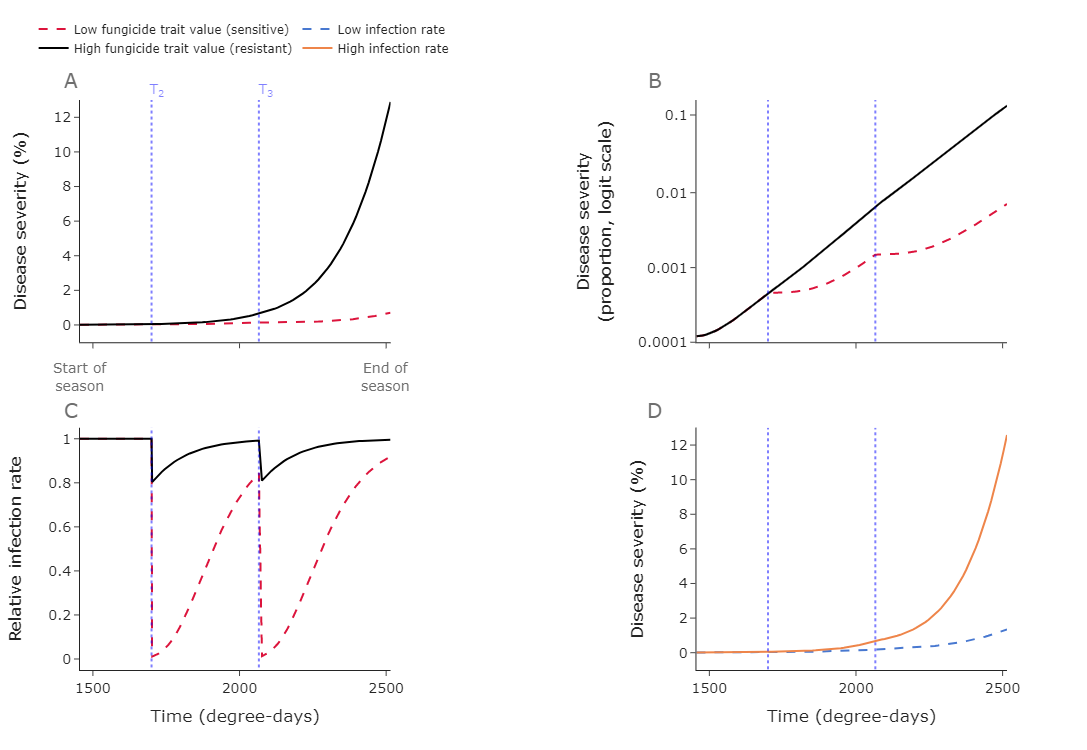

In [42]:
fig = within_season_fig(
    sev1,
    sev2,
    sevb1,
    sevb2,
    t,
    inf_rate_1,
    inf_rate_2
)

fig.show()

In [43]:
fig.write_image('../figures/paper_figs/fig1_draft.png')